In [77]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# архитектура модели +
# загрузчик данных +
# формирование батча +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [3]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F370AB7AA10>, 5)

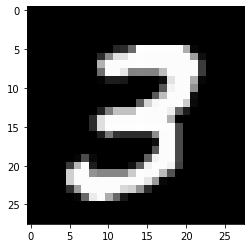

In [50]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[7].detach().numpy(), cmap='gray')
plt.show()

## Задача №1

In [86]:
class LinearModel(nn.Module):
  def __init__(self, input_dim, output_dim, dropout_p=0.2):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 128)
    self.linear4 = nn.Linear(128, 64)
    self.linear5 = nn.Linear(64, output_dim)
    self.do = nn.Dropout(dropout_p)
    self.activation = nn.Tanh()

  def forward(self, x):
    
    x = self.do(self.activation(self.linear1(x)))
    x = self.do(self.activation(self.linear2(x)))
    x = self.do(self.activation(self.linear3(x)))
    x = self.do(self.activation(self.linear4(x)))

    return self.linear5(x)

In [87]:
def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }


In [88]:
# hyperparams
inp_dim = 28 * 28
#hidden_dim = 128
out_dim = 10

n_epochs = 5
batch_size = 128

device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

In [89]:
model = LinearModel(inp_dim, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [90]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')


epoch: 0, step: 0, loss: 2.3004345893859863
epoch: 0, step: 200, loss: 0.30984485149383545
epoch: 0, step: 400, loss: 0.2156364470720291
epoch: 1, step: 0, loss: 0.1861196756362915
epoch: 1, step: 200, loss: 0.18279720842838287
epoch: 1, step: 400, loss: 0.1683962047100067
epoch: 2, step: 0, loss: 0.18205006420612335
epoch: 2, step: 200, loss: 0.12292097508907318
epoch: 2, step: 400, loss: 0.2699316442012787
epoch: 3, step: 0, loss: 0.10259149968624115
epoch: 3, step: 200, loss: 0.08932416886091232
epoch: 3, step: 400, loss: 0.13532747328281403
epoch: 4, step: 0, loss: 0.168833389878273
epoch: 4, step: 200, loss: 0.10156033933162689
epoch: 4, step: 400, loss: 0.09207360446453094


## Задача №2

In [113]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, output_dim, dropout_p=0.2):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.do = nn.Dropout(dropout_p)
    self.linear1 = nn.Linear(320, 50)
    self.flinear2 = nn.Linear(50, 10)
    self.activation = nn.Tanh()

  def forward(self, x):
      x = self.do(self.activation(F.max_pool2d(self.conv1(x), 2)))
      x = self.do(self.activation(F.max_pool2d(self.conv2(x), 2)))
      x = x.view(-1, 320)
      x = self.activation(self.linear1(x))

      return self.flinear2(x)

In [92]:
# hyperparams
inp_dim = 28 * 28
#hidden_dim = 128
out_dim = 10

n_epochs = 5
batch_size = 128

device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

In [101]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [114]:
model_conv = ConvModel(inp_dim, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [115]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model_conv.state_dict(), f'./chkpt_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3088526725769043
epoch: 0, step: 200, loss: 0.32435497641563416
epoch: 0, step: 400, loss: 0.16972562670707703
epoch: 1, step: 0, loss: 0.16519416868686676
epoch: 1, step: 200, loss: 0.08698617666959763
epoch: 1, step: 400, loss: 0.15040993690490723
epoch: 2, step: 0, loss: 0.0685548260807991
epoch: 2, step: 200, loss: 0.127103790640831
epoch: 2, step: 400, loss: 0.08107040077447891
epoch: 3, step: 0, loss: 0.09737628698348999
epoch: 3, step: 200, loss: 0.07471147924661636
epoch: 3, step: 400, loss: 0.034173231571912766
epoch: 4, step: 0, loss: 0.016989586874842644
epoch: 4, step: 200, loss: 0.08584369719028473
epoch: 4, step: 400, loss: 0.07621829956769943
